### AJ Data Pre-Processing

In [7]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re

#### Relevant Parameters of interest (user specific)

In [2]:
data_dir = os.getcwd()+'/Data/Juan/Run/'

test = pd.read_csv(data_dir+'Run_0205.csv')
test['timestamp'] = test.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)

In [3]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [4]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step. 
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    df = data.copy()
    
    if method == 'inference':
        raise ValueError('Method inference from session_start function is still under construction...come back later')
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [5]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None):
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several time series
    into a single one). For this purpose we will simply do individual pre-processing steps on each of the csv files and then
    merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    for session in session_files:
        
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='percentage', value=.02)
        print(re.findall('\d+', session)[0])
        print('Session Start: ' + str(min(df_start['timestamp'])))
        print('Session End: ' + str(max(df_start['timestamp'])))
        print()
        print('Session Length: ' + str(datetime.strptime(max(df_start['timestamp']), "%Y-%m-%d %H:%M:%S.%f")-
                                       datetime.strptime(min(df_start['timestamp']), "%Y-%m-%d %H:%M:%S.%f")))
        print('=================')
        full_df = pd.concat([full_df, df_start])        
        
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by=['timestamp'], inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
        
    return full_df
    

0205
Session Start: 2021-05-02 18:00:16.629
Session End: 2021-05-02 18:06:20.428

Session Length: 0:06:03.799000
0405
Session Start: 2021-05-04 18:58:39.120
Session End: 2021-05-04 19:04:34.166

Session Length: 0:05:55.046000
0705
Session Start: 2021-05-07 18:34:00.739
Session End: 2021-05-07 18:39:30.192

Session Length: 0:05:29.453000
1304
Session Start: 2021-04-13 18:50:38.821
Session End: 2021-04-13 18:54:21.910

Session Length: 0:03:43.089000
1504
Session Start: 2021-04-15 17:24:57.860
Session End: 2021-04-15 17:32:12.599

Session Length: 0:07:14.739000
1604
Session Start: 2021-04-16 19:17:10.348
Session End: 2021-04-16 19:23:54.668

Session Length: 0:06:44.320000
2104
Session Start: 2021-04-21 19:00:43.597
Session End: 2021-04-21 19:09:09.684

Session Length: 0:08:26.087000
2204
Session Start: 2021-04-22 19:14:33.233
Session End: 2021-04-22 19:20:17.773

Session Length: 0:05:44.540000
2404
Session Start: 2021-04-24 19:17:57.120
Session End: 2021-04-24 19:24:35.061

Session Length

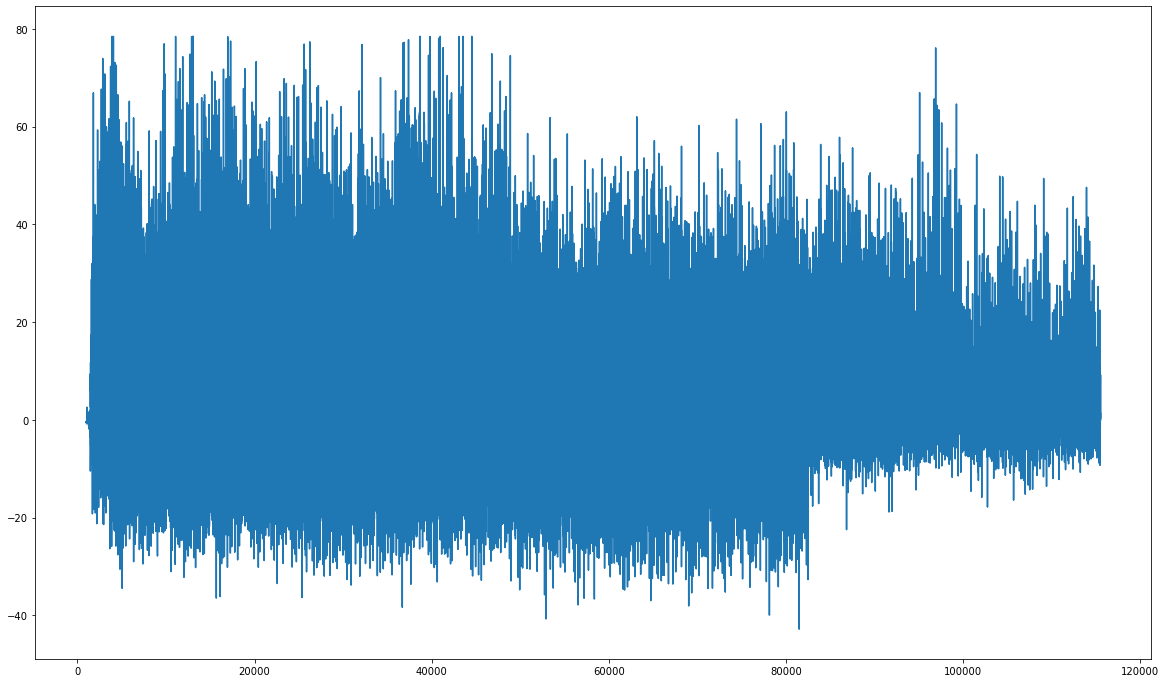

In [8]:
full = generate_full_time_series_AJ('Data/Juan/Run/', plot='AccX')

In [140]:
test.head(50)

,timestamp,AmbientLightSensor,DecibelSource,PitchSensor,LinearAccelerometerSensor,AccX,AccY,AccZ,CompassSensor,MagneticRotationSensor
0,2021-05-02 18:00:09.222,NaN,50.852644,237.802734,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-02 18:00:09.226,NaN,NaN,130.996094,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-02 18:00:09.230,NaN,NaN,NaN,1.286658,0.818405,0.729599,9.997421,238.743775,38.794033
3,2021-05-02 18:00:09.254,NaN,NaN,NaN,NaN,2.572357,0.978455,9.250854,252.124771,38.386735
4,2021-05-02 18:00:09.262,NaN,51.490057,130.996094,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-05-02 18:00:09.273,NaN,NaN,NaN,NaN,2.306747,0.679352,9.717468,241.218024,36.620165
6,2021-05-02 18:00:09.283,NaN,NaN,NaN,NaN,1.282623,0.720016,10.157745,237.837750,38.004247
7,2021-05-02 18:00:09.287,NaN,NaN,NaN,1.974719,NaN,NaN,NaN,NaN,NaN
8,2021-05-02 18:00:09.298,NaN,NaN,NaN,NaN,0.837555,0.827698,10.301315,239.220385,NaN
9,2021-05-02 18:00:09.302,NaN,50.603046,130.996094,NaN,NaN,NaN,NaN,239.962649,38.030030


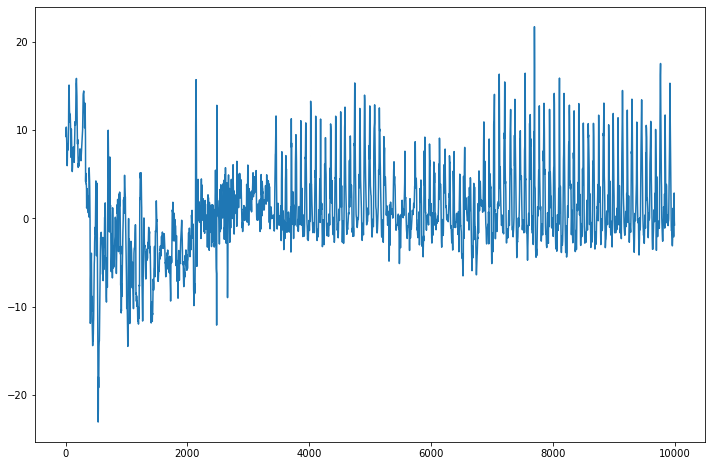

In [14]:
test_miss = missing_data_treatment(test, method='interpolation')
#print(test_miss.head(50))
plt.figure(figsize=(12,8))
plt.plot(test_miss['AccZ'][:10000])